In [3]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from types import SimpleNamespace
import matplotlib.pyplot as plt

from lib.Resnetworks import NetG_RES_GANomaly
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    classification_report,
    accuracy_score, precision_score,
    recall_score, f1_score
)

# -----------------------------------------------------------------------------
# 1) Helpers (unchanged)
# -----------------------------------------------------------------------------
def evaluate_scores(model, loader, device):
    model.eval()
    scores, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z_i, z_o = model(x)
            if z_i.ndim == 4:
                z_i = z_i.view(z_i.size(0), -1)
                z_o = z_o.view(z_o.size(0), -1)
            sc = torch.norm(z_i - z_o, p=2, dim=1).cpu().numpy()
            scores.append(sc)
            labels.append(y.cpu().numpy())
    return np.concatenate(scores), np.concatenate(labels)

def plot_score_distribution(scores, labels, xlim=(0, 10)):
    plt.figure(figsize=(8,6))
    plt.hist(scores[labels==0], bins=1000, alpha=0.6, label='Real', density=True)
    plt.hist(scores[labels==1], bins=1000, alpha=0.6, label='Anomaly', density=True)
    plt.legend()
    plt.xlabel("Anomaly score (‖zᵢ−zₒ‖₂)")
    plt.ylabel("Count")
    plt.title("Score distribution: real vs. anomaly")
    plt.xlim(xlim)
    plt.tight_layout()
    plt.show()

def print_classification_metrics(scores, labels):
    auc = roc_auc_score(labels, scores)
    print(f"ROC AUC: {auc:.4f}")
    fpr, tpr, thr = roc_curve(labels, scores)
    best_idx = np.argmax(tpr - fpr)
    best_thr = thr[best_idx]
    print(f"Best threshold (max TPR−FPR): {best_thr:.4f}\n")
    preds = (scores >= best_thr).astype(int)
    print("Classification report:")
    print(classification_report(labels, preds, target_names=['Real','Anomaly']))
    print("Accuracy :", accuracy_score(labels, preds))
    print("Precision:", precision_score(labels, preds))
    print("Recall   :", recall_score(labels, preds))
    print("F1-score :", f1_score(labels, preds))

# -----------------------------------------------------------------------------
# 2) Dataset (no per-sample normalization)
# -----------------------------------------------------------------------------
class WaveFakeDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        Expects:
          root_dir/
            real.npy      → shape [N_real,1,128,128]
            fake/         → .npy files each [n_i,1,128,128]
        """
        self.transform = transform
        self.data, self.labels = [], []

        # load real
        real_arr = np.load(os.path.join(root_dir, 'real.npy'))
        for sample in real_arr:
            self.data.append(sample)
            self.labels.append(0)

        # load fake
        fake_dir = os.path.join(root_dir, 'fake')
        for fp in sorted(glob.glob(os.path.join(fake_dir, '*.npy'))):
            arr = np.load(fp)
            for sample in arr:
                self.data.append(sample)
                self.labels.append(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        # NO per-sample normalization here
        if self.transform is not None:
            x = self.transform(x)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# -----------------------------------------------------------------------------
# 3) DataLoader (drop transform)
# -----------------------------------------------------------------------------

NetG_RES_GANomaly: Calculated ngf_deepest for decoder: 256


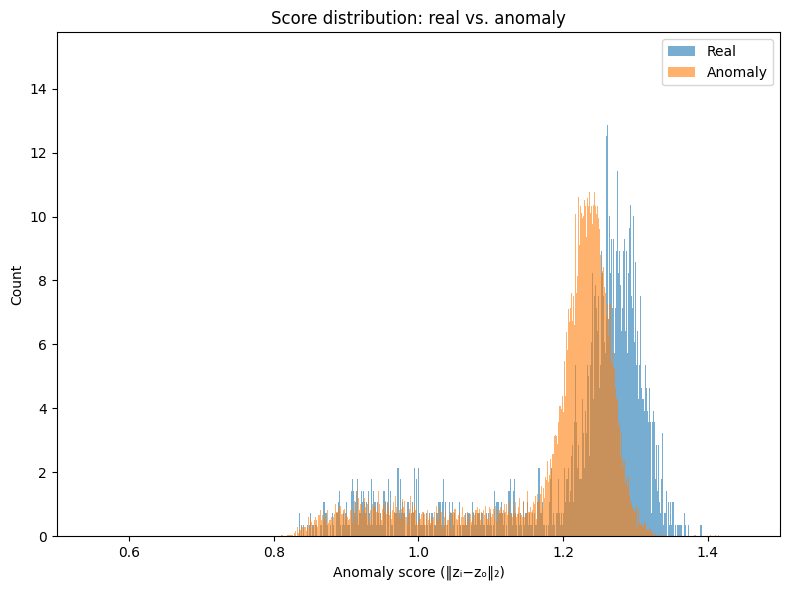

ROC AUC: 0.3215
Best threshold (max TPR−FPR): inf

Classification report:
              precision    recall  f1-score   support

        Real       0.12      1.00      0.22      4687
     Anomaly       0.00      0.00      0.00     32834

    accuracy                           0.12     37521
   macro avg       0.06      0.50      0.11     37521
weighted avg       0.02      0.12      0.03     37521

Accuracy : 0.12491671330721463
Precision: 0.0
Recall   : 0.0
F1-score : 0.0


/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/m

In [5]:
eval_root  = "/home/ml/Documents/voice/ResData/wavefake32_split/test"
batch_size = 8

eval_ds     = WaveFakeDataset(eval_root, transform=None)
eval_loader = DataLoader(eval_ds,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=1,
                         pin_memory=True)

# -----------------------------------------------------------------------------
# 4) Load model + checkpoint
# -----------------------------------------------------------------------------
opt = SimpleNamespace(
    nc=1, isize=32, nz=100, ngf=64, ngpu=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
device = torch.device(opt.device)

netG = NetG_RES_GANomaly(opt).to(device)
ckpt = torch.load(
    '/home/ml/Documents/voice/output_vanillaResGAN/FirstTime32/checkpoints/checkpoint_epoch480.pth',
    map_location=device
)
netG.load_state_dict(ckpt['netG'])

# -----------------------------------------------------------------------------
# 5) Evaluate & plot
# -----------------------------------------------------------------------------
scores, labels = evaluate_scores(netG, eval_loader, device)
plot_score_distribution(scores, labels, xlim=(0.5,1.5))
print_classification_metrics(scores, labels)

In [2]:
%cd ..

/home/ml/Documents/voice/Res_GANomaly/ganomaly


/home/ml/Documents/myenv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Train

NetG_RES_GANomaly: Calculated ngf_deepest for decoder: 256


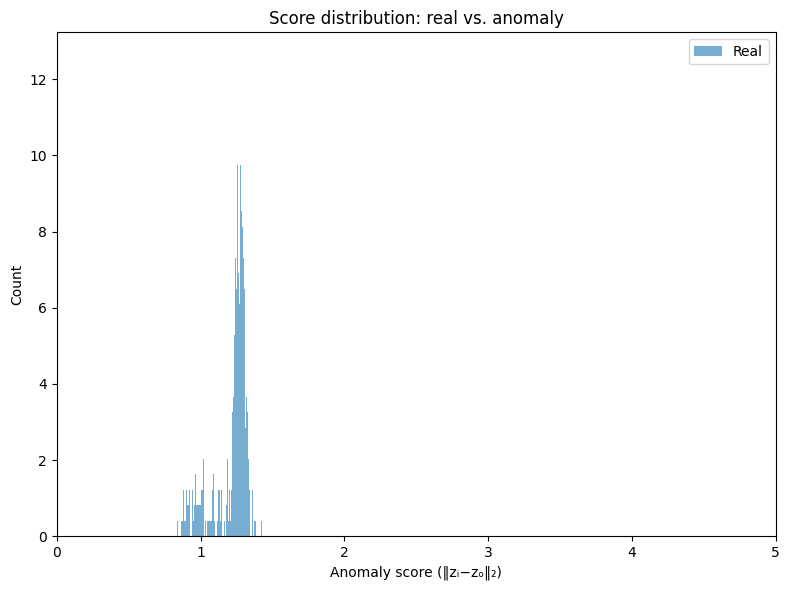

: 

In [ ]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from types import SimpleNamespace
import matplotlib.pyplot as plt

from lib.Resnetworks import NetG_RES_GANomaly
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    classification_report,
    accuracy_score, precision_score,
    recall_score, f1_score
)

# -----------------------------------------------------------------------------
# 1) Helpers (unchanged)
# -----------------------------------------------------------------------------
def evaluate_scores(model, loader, device):
    model.eval()
    scores, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z_i, z_o = model(x)
            if z_i.ndim == 4:
                z_i = z_i.view(z_i.size(0), -1)
                z_o = z_o.view(z_o.size(0), -1)
            sc = torch.norm(z_i - z_o, p=2, dim=1).cpu().numpy()
            scores.append(sc)
            labels.append(y.cpu().numpy())
    return np.concatenate(scores), np.concatenate(labels)

def plot_score_distribution(scores, labels, xlim=(0, 10)):
    plt.figure(figsize=(8,6))
    plt.hist(scores[labels==0], bins=5000, alpha=0.6, label='Real', density=True)
    #plt.hist(scores[labels==1], bins=25, alpha=0.6, label='Anomaly', density=True)
    plt.legend()
    plt.xlabel("Anomaly score (‖zᵢ−zₒ‖₂)")
    plt.ylabel("Count")
    plt.title("Score distribution: real vs. anomaly")
    plt.xlim(xlim)
    plt.tight_layout()
    plt.show()

def print_classification_metrics(scores, labels):
    auc = roc_auc_score(labels, scores)
    print(f"ROC AUC: {auc:.4f}")
    fpr, tpr, thr = roc_curve(labels, scores)
    best_idx = np.argmax(tpr - fpr)
    best_thr = thr[best_idx]
    print(f"Best threshold (max TPR−FPR): {best_thr:.4f}\n")
    preds = (scores >= best_thr).astype(int)
    print("Classification report:")
    print(classification_report(labels, preds, target_names=['Real','Anomaly']))
    print("Accuracy :", accuracy_score(labels, preds))
    print("Precision:", precision_score(labels, preds))
    print("Recall   :", recall_score(labels, preds))
    print("F1-score :", f1_score(labels, preds))

# -----------------------------------------------------------------------------
# 2) Dataset (no per-sample normalization)
# -----------------------------------------------------------------------------
class WaveFakeDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        Expects:
          root_dir/
            real.npy      → shape [N_real,1,128,128]
            fake/         → .npy files each [n_i,1,128,128]
        """
        self.transform = transform
        self.data, self.labels = [], []

        # load real
        real_arr = np.load(os.path.join(root_dir, 'real.npy'))
        for sample in real_arr:
            self.data.append(sample)
            self.labels.append(0)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        # NO per-sample normalization here
        if self.transform is not None:
            x = self.transform(x)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# -----------------------------------------------------------------------------
# 3) DataLoader (drop transform)
# -----------------------------------------------------------------------------
eval_root  = "/home/ml/Documents/voice/ResData/wavefake32_split/train"
batch_size = 16

eval_ds     = WaveFakeDataset(eval_root, transform=None)
eval_loader = DataLoader(eval_ds,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=1,
                         pin_memory=True)

# -----------------------------------------------------------------------------
# 4) Load model + checkpoint
# -----------------------------------------------------------------------------
opt = SimpleNamespace(
    nc=1, isize=32, nz=100, ngf=64, ngpu=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
device = torch.device(opt.device)

netG = NetG_RES_GANomaly(opt).to(device)
ckpt = torch.load(
    '/home/ml/Documents/voice/output_vanillaResGAN/FirstTime32/checkpoints/checkpoint_epoch480.pth',
    map_location=device
)
netG.load_state_dict(ckpt['netG'])

# -----------------------------------------------------------------------------
# 5) Evaluate & plot
# -----------------------------------------------------------------------------
scores, labels = evaluate_scores(netG, eval_loader, device)
plot_score_distribution(scores, labels, xlim=(0,5))
# print_classification_metrics(scores, labels)


# Fake as Bonafide

In [1]:
import os, torch, pprint
pth = "/home/ml/Documents/voice/output_multigan/FirstTime64/checkpoints/checkpoint_interrupt_epoch129.pth"

print("size:", os.path.getsize(pth), "bytes")   # should be MBs, not a few KB
ckpt = torch.load(pth, map_location="cpu")      # crash here? → file is corrupt
pprint.pprint(ckpt.keys())                      # expect: epoch, netG, netD, optG, optD
print("decoders saved:", len(ckpt["optG"]))


size: 809890601 bytes


RuntimeError: PytorchStreamReader failed locating file data/4: file not found